# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [3]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - number of gameweeks required
FFP = 15

NEXT_GAMEWEEK = 19

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Data

In [5]:
df = pd.read_csv('data/fpl_fbref_elo_players.csv')

In [6]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [7]:
# remembering original df
df_original = df

In [8]:
df.head(20)

,Date,Day,Comp,Round,Venue,Squad,Opponent,Start,Pos,Min,...,GoalsTeams,Team Score,Opp Score,CS,Was Home,GW,FPL,neutral_name,Total Points,Opp rating
0,2022-08-06,Sat,Premier League,Matchweek 1,Home,Leeds United,Wolves,Y,RW,83.0,...,2–1,2,1,0.0,1.0,1,2.0,Brenden-Aaronson,2.0,1725.276489
1,2022-08-13,Sat,Premier League,Matchweek 2,Away,Leeds United,Southampton,Y,"RW,AM",90.0,...,2–2,2,2,0.0,0.0,2,2.0,Brenden-Aaronson,1.0,1667.049927
2,2022-08-21,Sun,Premier League,Matchweek 3,Home,Leeds United,Chelsea,Y,AM,82.0,...,3–0,3,0,1.0,1.0,3,8.0,Brenden-Aaronson,8.0,1901.388306
3,2022-08-27,Sat,Premier League,Matchweek 4,Away,Leeds United,Brighton,Y,"AM,RW",81.0,...,0–1,0,1,0.0,0.0,4,2.0,Brenden-Aaronson,1.0,1783.540161
4,2022-08-30,Tue,Premier League,Matchweek 5,Home,Leeds United,Everton,Y,"AM,RW",75.0,...,1–1,1,1,0.0,1.0,5,5.0,Brenden-Aaronson,5.0,1688.922485
5,2022-09-03,Sat,Premier League,Matchweek 6,Away,Leeds United,Brentford,Y,AM,90.0,...,2–5,2,5,0.0,0.0,6,2.0,Brenden-Aaronson,2.0,1727.113647
6,2022-10-02,Sun,Premier League,Matchweek 9,Home,Leeds United,Aston Villa,Y,"AM,CM",78.0,...,0–0,0,0,1.0,1.0,9,3.0,Brenden-Aaronson,3.0,1716.016846
7,2022-10-09,Sun,Premier League,Matchweek 10,Away,Leeds United,Crystal Palace,Y,"RW,AM",75.0,...,1–2,1,2,0.0,0.0,10,2.0,Brenden-Aaronson,5.0,1748.905396
8,2022-10-16,Sun,Premier League,Matchweek 11,Home,Leeds United,Arsenal,Y,"RW,DM",90.0,...,0–1,0,1,0.0,1.0,11,2.0,Brenden-Aaronson,2.0,1908.041016
9,2022-10-20,Thu,Premier League,Matchweek 12,Away,Leeds United,Leicester City,Y,"DM,AM",90.0,...,0–2,0,2,0.0,0.0,12,2.0,Brenden-Aaronson,2.0,1730.854736


In [9]:
info = ["Name", "GW"]
other = ["LSTM"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [10]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

C:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [11]:
df.shape

(7457, 12)

In [12]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking onyl players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [13]:
df.shape

(5844, 12)

In [14]:
df.head(20)

,Name,GW,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,1,83.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
1,Brenden-Aaronson,2,90.0,0.0,2.0,0.0,0.1,0.1,0.1,0.0,0.0,2.0
2,Brenden-Aaronson,3,82.0,1.0,2.0,2.0,1.0,1.0,0.1,1.0,1.0,8.0
3,Brenden-Aaronson,4,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,Brenden-Aaronson,5,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
5,Brenden-Aaronson,6,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
6,Brenden-Aaronson,9,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
7,Brenden-Aaronson,10,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
8,Brenden-Aaronson,11,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
9,Brenden-Aaronson,12,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0


In [15]:
last_names = df["Name"].unique()

# DF to DataLoader

In [16]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [17]:
index_table = init_index_table(df)

In [18]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        length = 0
        for name in self.names:
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = index_table[idx]
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS - 1)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [19]:
dataset = PandasDataset(df)
dataset.__getitem__(3307)

(array([[82. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [90. ,  1. ,  3. ,  1. ,  0.2,  0.2,  0.6,  1. ,  1. ],
        [86. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.2,  1. ,  0. ],
        [90. ,  2. ,  3. ,  2. ,  1.5,  1.5,  0. ,  1. ,  0. ],
        [90. ,  0. ,  6. ,  0. ,  0.4,  0.4,  1.1,  0. ,  1. ],
        [86. ,  1. ,  1. ,  1. ,  0.1,  0.1,  0.8,  0. ,  0. ],
        [90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.3,  1. ,  1. ]],
       dtype=float32),
 2.0)

In [20]:
dataset.__len__()

3308

In [21]:
batch_size = 16

In [22]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [23]:
# next(iter(dataloader))[1]

# LSTM Model

In [24]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [25]:
len(dataloader)

207

In [26]:
# torch.transpose(next(iter(dataloader))[0], 0, 1).shape

In [27]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loop

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [37]:
%%time
num_epochs = 30
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2)
        # print("INPUTS", inputs.shape)
        # print("TARGETS", targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs).flatten()
        # print("OUTPUTS", outputs.shape)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    # if epoch % 5 == 0:
    print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

Epoch 0 Loss: 3.1018799277751343
Epoch 1 Loss: 3.0975462412776578
Epoch 2 Loss: 3.0853098647461996
Epoch 3 Loss: 3.099764109881604
Epoch 4 Loss: 3.1346432796998878
Epoch 5 Loss: 3.1104155210913094
Epoch 6 Loss: 3.0928161543060617
Epoch 7 Loss: 3.1093466033538184
Epoch 8 Loss: 3.08778181153795
Epoch 9 Loss: 3.080126758358905
Epoch 10 Loss: 3.139688099352058
Epoch 11 Loss: 3.0627878917300184
Epoch 12 Loss: 3.0394894069663567
Epoch 13 Loss: 3.0312656396685016
Epoch 14 Loss: 3.024851245796623
Epoch 15 Loss: 3.0719973028857925
Epoch 16 Loss: 3.098119248802535
Epoch 17 Loss: 3.058819764478195
Epoch 18 Loss: 3.0479788020757086
Epoch 19 Loss: 3.038062129475644
Epoch 20 Loss: 3.057848173207131
Epoch 21 Loss: 3.065478425382992
Epoch 22 Loss: 3.0059594263633094
Epoch 23 Loss: 3.0268170130281633
Epoch 24 Loss: 3.0378511375275212
Epoch 25 Loss: 3.0058058019421527
Epoch 26 Loss: 2.986995759073663
Epoch 27 Loss: 3.011658818105569
Epoch 28 Loss: 2.991023862707442
Epoch 29 Loss: 3.0048191643855424
CPU 

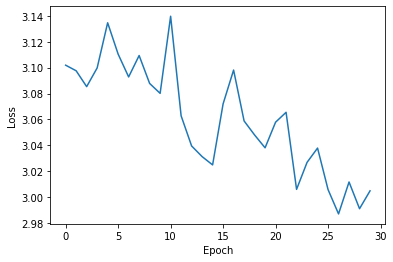

In [38]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [39]:
index = 0
predictions = []
for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    # print("INPUTS", inputs)
    # print(inputs)
    outputs = net(inputs)
    # print("OUTPUTS", outputs)
    for output in outputs:
        player_id, sample_id = index_table[index]
        name = last_names[player_id]
        points = round(output.item(), 2)
        gw = sample_id + FIS + 1
        predictions.append([name, gw, points])
        # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
        index += 1

In [40]:
# appending results to original df
for name, gw, points in predictions:
    df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [41]:
df_original

,Date,Day,Comp,Round,Venue,Squad,Opponent,Start,Pos,Min,...,Team Score,Opp Score,CS,Was Home,GW,FPL,neutral_name,Total Points,Opp rating,LSTM
0,2022-08-06,Sat,Premier League,Matchweek 1,Home,Leeds United,Wolves,Y,RW,83.0,...,2,1,0.0,1.0,1,2.0,Brenden-Aaronson,2.0,1725.276489,NaN
1,2022-08-13,Sat,Premier League,Matchweek 2,Away,Leeds United,Southampton,Y,"RW,AM",90.0,...,2,2,0.0,0.0,2,2.0,Brenden-Aaronson,1.0,1667.049927,NaN
2,2022-08-21,Sun,Premier League,Matchweek 3,Home,Leeds United,Chelsea,Y,AM,82.0,...,3,0,1.0,1.0,3,8.0,Brenden-Aaronson,8.0,1901.388306,NaN
3,2022-08-27,Sat,Premier League,Matchweek 4,Away,Leeds United,Brighton,Y,"AM,RW",81.0,...,0,1,0.0,0.0,4,2.0,Brenden-Aaronson,1.0,1783.540161,NaN
4,2022-08-30,Tue,Premier League,Matchweek 5,Home,Leeds United,Everton,Y,"AM,RW",75.0,...,1,1,0.0,1.0,5,5.0,Brenden-Aaronson,5.0,1688.922485,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7452,2022-12-26,Mon,Premier League,Matchweek 17,Home,Arsenal,West Ham,Y*,RM,90.0,...,3,1,0.0,1.0,17,8.0,Martin-Odegaard,11.0,1768.070923,5.62
7453,2022-12-31,Sat,Premier League,Matchweek 18,Away,Arsenal,Brighton,Y*,RM,86.0,...,4,2,0.0,0.0,18,10.0,Martin-Odegaard,13.0,1799.850708,4.95
7454,2023-01-03,Tue,Premier League,Matchweek 19,Home,Arsenal,Newcastle Utd,Y*,RM,90.0,...,0,0,1.0,1.0,19,3.0,Martin-Odegaard,NaN,1850.296631,NaN
7455,2023-01-15,Sun,Premier League,Matchweek 20,Away,Arsenal,Tottenham,Y*,RM,89.0,...,2,0,1.0,0.0,20,8.0,Martin-Odegaard,NaN,1868.577759,NaN


In [42]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

In [43]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
3300,Martin-Odegaard,11,6.29
1399,Son-Heung-min,18,6.28
1297,Erling-Haaland,9,6.22
1566,Harry-Kane,20,6.17
2950,Ivan-Toney,18,6.15
103,Miguel-Almiron,14,6.08
105,Miguel-Almiron,16,6.06
1557,Harry-Kane,11,6.06
1300,Erling-Haaland,12,6.06
3185,Callum-Wilson,12,6.04
